<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/resnet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

Cloning into 'medical-image-analysis'...
remote: Enumerating objects: 3779, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 3779 (delta 6), reused 0 (delta 0), pack-reused 3763
Receiving objects: 100% (3779/3779), 336.93 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (3886/3886), done.


In [6]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tensorflow.keras import backend as K
import gc
from functools import partial
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import json
import itertools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D 
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing import image
from glob import glob

In [7]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [8]:
eczema_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Eczema Photos", 224))
melanoma_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


100%|██████████| 352/352 [00:02<00:00, 139.03it/s]


In [9]:
#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melanoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

In [10]:
X_train = np.concatenate((eczema_train, melanoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)
X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)
print(Y_test.shape)
print(X_test.shape)

(777,)
(777, 224, 224, 3)


In [11]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [12]:
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.3, 
    random_state=5
)

In [ ]:
X_train.shape, Y_train.shape

((2172, 224, 224, 3), (2172, 3))

In [ ]:
X_val.shape, Y_val.shape

((931, 224, 224, 3), (931, 3))

In [ ]:
X_test.shape, Y_test.shape

((777, 224, 224, 3), (777, 3))

In [13]:
pre_trained_model = tensorflow.keras.applications.ResNet50(input_shape=(224,224, 3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 1s 0us/step


In [14]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [15]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 2048)


In [16]:
x = tensorflow.keras.layers.Flatten()(last_output)
x = tensorflow.keras.layers.Dense(512, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(512, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(3, activation='softmax')(x)

#Config and compile model

model1 = Model(pre_trained_model.input, x)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

TRAINING

In [17]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [19]:
batch_size = 64
epochs = 5
history0 = model1.fit_generator(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
33/33 [==============================] - 43s 1s/step - loss: 2.2559 - accuracy: 0.4583 - val_loss: 60742476.0000 - val_accuracy: 0.4040
Epoch 2/5
33/33 [==============================] - 39s 1s/step - loss: 1.1644 - accuracy: 0.5128 - val_loss: 751.7477 - val_accuracy: 0.3839
Epoch 3/5
33/33 [==============================] - 39s 1s/step - loss: 0.9485 - accuracy: 0.5464 - val_loss: 4.0548 - val_accuracy: 0.2946
Epoch 4/5
33/33 [==============================] - 39s 1s/step - loss: 0.9146 - accuracy: 0.5674 - val_loss: 0.9478 - val_accuracy: 0.5469
Epoch 5/5
33/33 [==============================] - 40s 1s/step - loss: 0.9066 - accuracy: 0.5835 - val_loss: 0.8619 - val_accuracy: 0.6161


In [20]:
model1.save("0thModel.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
type(model1)

tensorflow.python.keras.engine.functional.Functional

In [23]:
print(history0.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [40]:
print(history0.history['val_accuracy'])

[0.4040178656578064, 0.3839285671710968, 0.2946428656578064, 0.546875, 0.6160714030265808]


**FINE TUNING**

In [24]:
for layer in pre_trained_model.layers[5:10]:
    layer.trainable = True

In [25]:
model2 = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [28]:
batch_size = 64
epochs = 5
history1 = model2.fit_generator(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
33/33 [==============================] - 45s 1s/step - loss: 0.8995 - acc: 0.6105 - val_loss: 0.8053 - val_acc: 0.6384
Epoch 2/5
33/33 [==============================] - 39s 1s/step - loss: 0.9494 - acc: 0.5844 - val_loss: 0.8028 - val_acc: 0.6295
Epoch 3/5
33/33 [==============================] - 39s 1s/step - loss: 0.8917 - acc: 0.5840 - val_loss: 0.7852 - val_acc: 0.6406
Epoch 4/5
33/33 [==============================] - 39s 1s/step - loss: 0.8360 - acc: 0.6086 - val_loss: 0.7581 - val_acc: 0.6741
Epoch 5/5
33/33 [==============================] - 39s 1s/step - loss: 0.8211 - acc: 0.6276 - val_loss: 0.7667 - val_acc: 0.6540


In [41]:
model2.save("1stModel.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
print(history1.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


In [39]:
print(history1.history['val_acc'])

[0.6383928656578064, 0.6294642686843872, 0.640625, 0.6741071343421936, 0.6540178656578064]


Text(0.5, 1.0, 'Training and validation loss')

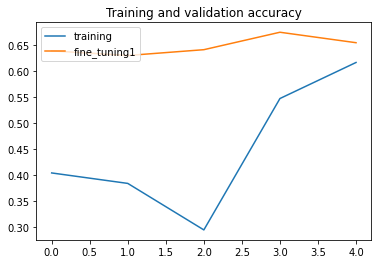

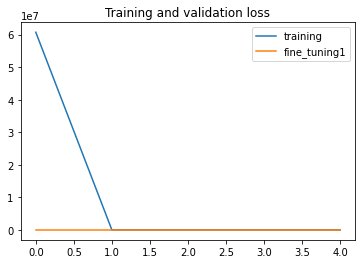

In [43]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc0 = np.array(history0.history['val_accuracy'])
acc1 = np.array(history1.history['val_acc'])

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss0 = history0.history['val_loss']
loss1 = history1.history['val_loss']

# Get number of epochs
epochs = range(len(acc0))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc0, label = "training")
plt.plot(epochs, acc1, label = "fine_tuning1")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss0, label = "training")
plt.plot(epochs, loss1, label = "fine_tuning1")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
loss_test, acc_test = model.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

25/25 [==============================] - 4s 112ms/step - loss: 0.6286 - acc: 0.7066
Test: accuracy = 0.706564  ;  loss = 0.628615


In [ ]:
model.save("InceptionResNet.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [37]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

NameError: ignored

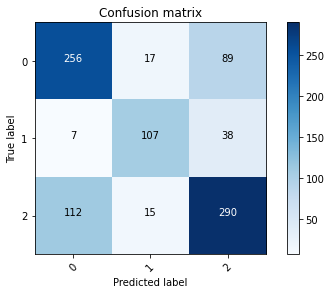

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [1]:
!git config --global user.name "snehahs03"

In [2]:
!git config --global user.email hssneha03@gmail.com

In [3]:
!git init

Initialized empty Git repository in /content/.git/


In [4]:
!git add .

In [5]:
!git status

On branch master

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)

	new file:   .config/.last_opt_in_prompt.yaml
	new file:   .config/.last_survey_prompt.yaml
	new file:   .config/.last_update_check.json
	new file:   .config/active_config
	new file:   .config/config_sentinel
	new file:   .config/configurations/config_default
	new file:   .config/gce
	new file:   .config/logs/2021.06.15/13.36.40.402408.log
	new file:   .config/logs/2021.06.15/13.36.59.704686.log
	new file:   .config/logs/2021.06.15/13.37.15.895583.log
	new file:   .config/logs/2021.06.15/13.37.22.745818.log
	new file:   .config/logs/2021.06.15/13.37.39.858399.log
	new file:   .config/logs/2021.06.15/13.37.40.569743.log
	new file:   sample_data/README.md
	new file:   sample_data/anscombe.json
	new file:   sample_data/california_housing_test.csv
	new file:   sample_data/california_housing_train.csv
	new file:   sample_data/mnist_test.csv
	new file:   sample_data/mnist_train_small.cs